# Bot Detection EDA 

Course: Theoretical and Applicational Aspects of Modern Cyber(66219) <br/>
Lecturer: Dr. Uri Itai<br/>
Student: Idan Gabai<br/>

## Background

I did EDA on the bot detecion datasets in X (twitter).
<br/><a href="https://botometer.osome.iu.edu/bot-repository/datasets.html">link to repository</a> it might takse a minute for the page to load.<br/>

I took the following datasets: "botwiki-2019", "celebrity-2019", "cresci-rtbust-2019",
"cresci-stock-2018",<br/> "gilani-2017", "political-bots-2019", "pronbots-2019",
"vendor-purchased-2019", "verified-2019"

In [1]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.linear_model import RidgeClassifier,SGDClassifier
from xgboost import XGBClassifier



%matplotlib inline

In [2]:
# Function to read and process each dataset
def process_dataset(name):
    merged = None
    label_file = Path(f"./data/{name}/{name}.tsv")
    data_file = Path(f"./data/{name}/{name}_tweets.json")
    
    labels = pd.read_csv(label_file, sep='\t', header=None, names=['user_id', 'label'])
    
    # print(data_file) #left for debug purpose
    with open(data_file, 'r', encoding='utf-8') as f:
        data1 = json.load(f)
        data = pd.json_normalize(data1)

        # print(data.columns)
        
        # Merge labels with data
        merged = pd.merge(data,labels, right_on='user_id', left_on='user.id', how='inner')
        merged['dataset'] = name
    
    return merged

In [3]:
datasets = [
    "botwiki-2019", "celebrity-2019", "cresci-rtbust-2019",
    "cresci-stock-2018", "gilani-2017", "political-bots-2019", "pronbots-2019",
    "vendor-purchased-2019", "verified-2019"
    ]

In [4]:
# Concatenate all datasets
all_data = pd.concat([process_dataset(name) for name in datasets], ignore_index=True)

Total number of records: 44106

Distribution of bot vs human accounts:
bot      28274
human    15832
Name: label, dtype: int64

Total Number of records per dataset:
pronbots-2019            17882
cresci-stock-2018        13276
celebrity-2019            5918
gilani-2017               2503
verified-2019             1987
vendor-purchased-2019     1087
botwiki-2019               698
cresci-rtbust-2019         693
political-bots-2019         62
Name: dataset, dtype: int64


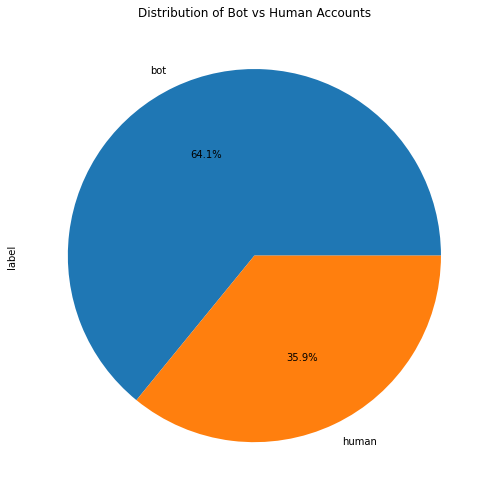

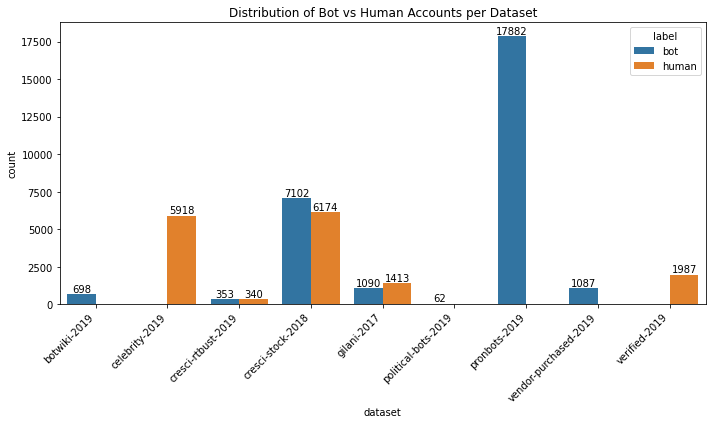

In [5]:
# Basic overview
print(f"Total number of records: {len(all_data)}")
print(f"\nDistribution of bot vs human accounts:")
print(all_data['label'].value_counts(normalize=False))

plt.figure(figsize=(10, 6))
pie_df = all_data['label'].value_counts()
plot = pie_df.plot.pie( figsize=(7, 7), autopct='%1.1f%%', startangle=0)
plt.title('Distribution of Bot vs Human Accounts')
plt.tight_layout()


print("\nTotal Number of records per dataset:")
print(all_data['dataset'].value_counts())

# Plot distribution of bot vs human accounts
plt.figure(figsize=(10, 6))
ax=sns.countplot(x='dataset', hue='label', data=all_data)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]) 
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Bot vs Human Accounts per Dataset')
plt.tight_layout()



In [6]:
all_data.shape

(44106, 48)

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44106 entries, 0 to 44105
Data columns (total 48 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   created_at                               44106 non-null  object 
 1   user.id                                  44106 non-null  int64  
 2   user.id_str                              44106 non-null  object 
 3   user.name                                44106 non-null  object 
 4   user.screen_name                         44106 non-null  object 
 5   user.location                            44106 non-null  object 
 6   user.description                         44106 non-null  object 
 7   user.url                                 12447 non-null  object 
 8   user.entities.url.urls                   12447 non-null  object 
 9   user.entities.description.urls           44106 non-null  object 
 10  user.protected                           44106

Duplicated

In [8]:
all_data = all_data.drop_duplicates(subset=['user_id','user.name','user.screen_name'],keep='last').reset_index(drop=True)

In [9]:
all_data.duplicated(subset=['user_id','user.name','user.screen_name']).sum()

0

In [10]:
all_data.shape

(43892, 48)

### Numeric Columns EDA

In [11]:
different_id = all_data[all_data['user.id'] != all_data['user_id']]
different_id

,created_at,user.id,user.id_str,user.name,user.screen_name,user.location,user.description,user.url,user.entities.url.urls,user.entities.description.urls,...,user.default_profile,user.default_profile_image,user.following,user.follow_request_sent,user.notifications,user.translator_type,user_id,label,dataset,user.withheld_in_countries


In [12]:
numeric = all_data.select_dtypes('number').copy()
numeric.drop('user_id',axis=1,inplace=True)
numeric.drop('user.id',axis=1,inplace=True)
numeric.columns

Index(['user.followers_count', 'user.friends_count', 'user.listed_count',
       'user.favourites_count', 'user.utc_offset', 'user.statuses_count'],
      dtype='object')

In [13]:
numeric_features = [ 'user.followers_count', 'user.listed_count', 
                        'user.statuses_count', 'user.friends_count', 'user.favourites_count']

In [14]:
def plot_feature_by_account_type(df,feature, log_scale=False):
    fig, axs = plt.subplots(1,2,figsize=(10, 6))
    plt.title(f'{feature} Distribution by Account Type')
    sns.boxplot(x='label', y=feature,hue='label', data=df, ax=axs[0], log_scale=log_scale)
    sns.violinplot(x="label", y=feature, hue="label", data=df, split=True, inner="quart", ax=axs[1])
    plt.xticks(rotation=90)
    
    if log_scale:
        plt.yscale('log')
    plt.tight_layout()
    plt.show()

user.followers_count

user.followers_count statistics by account type:
         count           mean           std  min    25%     50%       75%  \
label                                                                       
bot    28251.0   31287.446674  6.415992e+05  0.0    9.0    21.0      54.0   
human  15641.0  772516.576114  3.310260e+06  0.0  282.0  7761.0  573712.0   

               max  
label               
bot     42709246.0  
human  106938028.0  


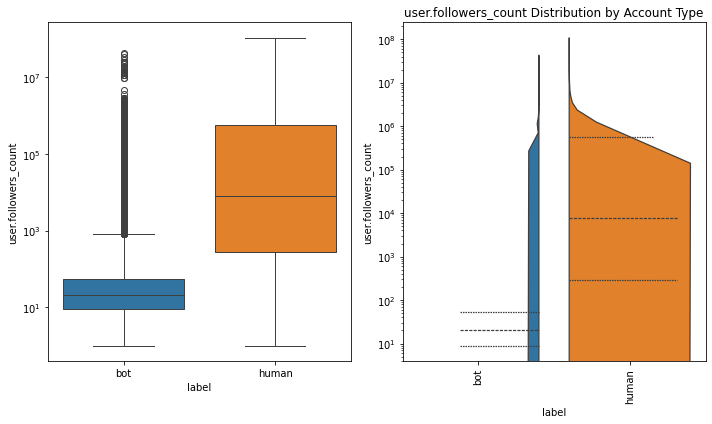

user.friends_count

user.friends_count statistics by account type:
         count         mean           std  min    25%    50%     75%  \
label                                                                  
bot    28251.0  3350.009062  48874.661473  0.0    0.0    0.0    76.0   
human  15641.0  6492.292053  55523.633992  0.0  118.0  422.0  1060.0   

             max  
label             
bot    4249178.0  
human  1862485.0  


c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


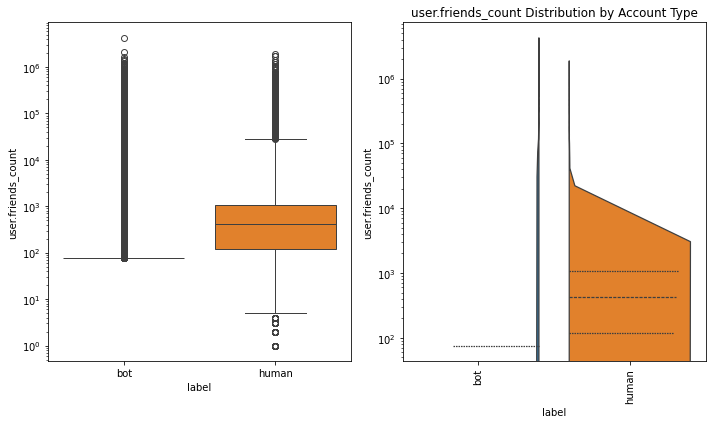

user.listed_count

user.listed_count statistics by account type:
         count         mean           std  min  25%    50%     75%        max
label                                                                        
bot    28251.0   110.854695   2334.861734  0.0  0.0    0.0     0.0   198862.0
human  15641.0  2105.285851  27181.041614  0.0  2.0  117.0  1248.0  3233474.0


c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


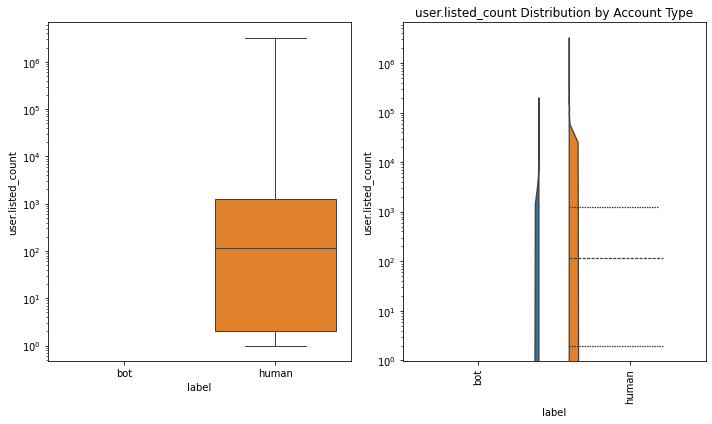

user.favourites_count

user.favourites_count statistics by account type:
         count         mean           std  min    25%     50%     75%  \
label                                                                   
bot    28251.0  1718.627164  13208.007160  0.0  129.0   272.0   930.5   
human  15641.0  9361.294099  24029.834377  0.0  218.0  1740.0  7949.0   

            max  
label            
bot    886115.0  
human  572806.0  


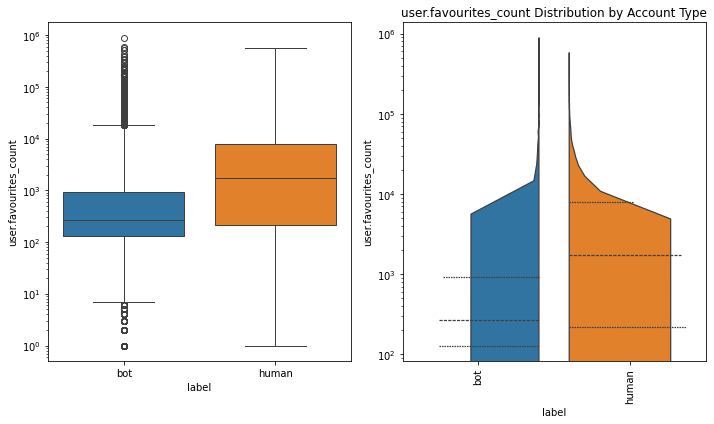

user.utc_offset

user.utc_offset statistics by account type:
        count         mean           std      min      25%      50%     75%  \
label                                                                         
bot    2804.0 -5207.417974  20635.435387 -39600.0 -25200.0 -10800.0  7200.0   
human  5111.0 -7981.843084  17797.260476 -39600.0 -21600.0 -14400.0  7200.0   

           max  
label           
bot    46800.0  
human  46800.0  


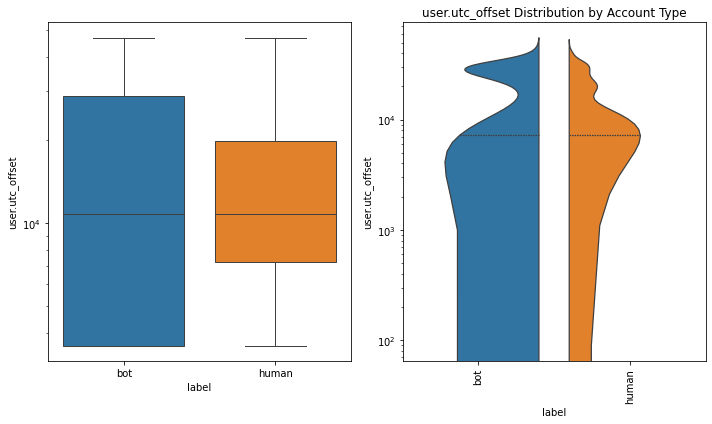

user.statuses_count

user.statuses_count statistics by account type:
         count          mean           std  min     25%     50%      75%  \
label                                                                      
bot    28251.0   8212.539945  59897.321898  1.0    33.0    88.0   1745.5   
human  15641.0  20915.087654  46268.034098  1.0  2107.0  7544.0  22375.0   

             max  
label             
bot    2766520.0  
human  1710193.0  


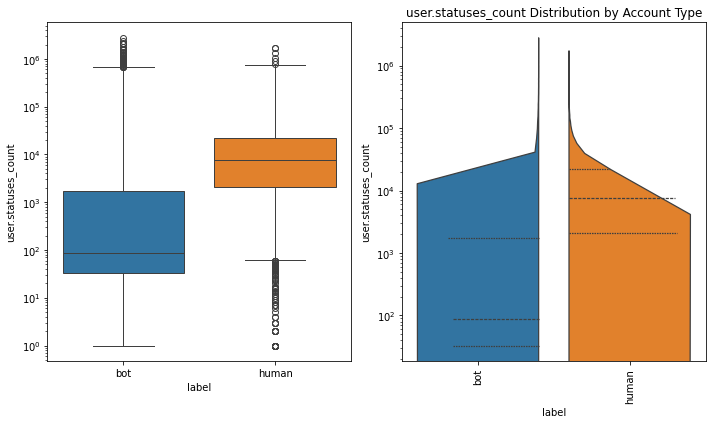

In [15]:
for num_feature in numeric.columns:
    print(num_feature)
    print(f"\n{num_feature} statistics by account type:")
    print(all_data.groupby('label')[num_feature].describe())
    plot_feature_by_account_type(all_data, num_feature,True)

### Categorical data

#### Boolean Data

we have 14 columns of bool data, let's have a look on the 7 more interesting columns<br>
* user.geo_enabled
* user.verified
* user.profile_background_tile
* user.profile_use_background_image
* user.has_extended_profile
* user.default_profile
* user.default_profile_image

In [16]:
bool_cols = [
"user.geo_enabled",
"user.verified",
"user.profile_background_tile",
"user.profile_use_background_image",
"user.has_extended_profile",
"user.default_profile",
"user.default_profile_image"
]

In [17]:
def crosstab(f1,f2,df):
    print(f"crosstab f1:{f1}, f2:{f2}")
    res = pd.crosstab(df[f1],df[f2])
    print(res)
    return res

In [18]:
f2=  'label'
for b_col in bool_cols:
    crosstab(b_col,f2,all_data)

crosstab f1:user.geo_enabled, f2:label
label               bot  human
user.geo_enabled              
False             24659   7130
True               3592   8511
crosstab f1:user.verified, f2:label
label            bot  human
user.verified              
False          27932   8863
True             319   6778
crosstab f1:user.profile_background_tile, f2:label
label                           bot  human
user.profile_background_tile              
False                         25616  10874
True                           2635   4767
crosstab f1:user.profile_use_background_image, f2:label
label                                bot  human
user.profile_use_background_image              
False                               1467   2376
True                               26784  13265
crosstab f1:user.has_extended_profile, f2:label
label                        bot  human
user.has_extended_profile              
False                      25494  10200
True                        2757   5441
crosstab f

#### Multi-class categorical data

In [19]:
cat_data = all_data.select_dtypes('object').copy()
cat_data.drop(columns=['user.id_str','dataset'], axis=1)
cat_data.columns

Index(['created_at', 'user.id_str', 'user.name', 'user.screen_name',
       'user.location', 'user.description', 'user.url',
       'user.entities.url.urls', 'user.entities.description.urls',
       'user.created_at', 'user.time_zone', 'user.lang',
       'user.profile_background_color', 'user.profile_background_image_url',
       'user.profile_background_image_url_https', 'user.profile_image_url',
       'user.profile_image_url_https', 'user.profile_banner_url',
       'user.profile_link_color', 'user.profile_sidebar_border_color',
       'user.profile_sidebar_fill_color', 'user.profile_text_color',
       'user.translator_type', 'label', 'dataset',
       'user.withheld_in_countries'],
      dtype='object')

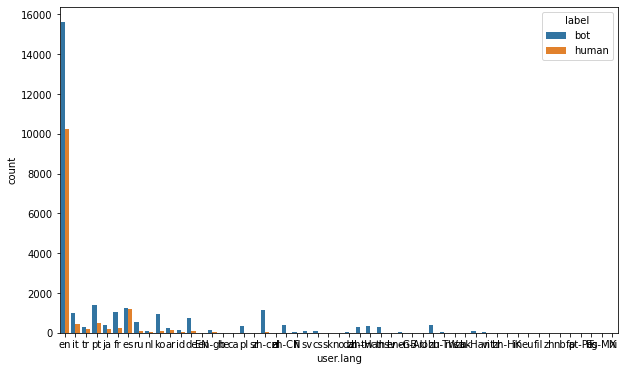

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='user.lang',hue='label',data=cat_data)
plt.show()

In [21]:
def categorical_eda(df, max_categories=15,min_count=1000):
    # Get categorical columns with less than max_categories unique values
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # cat_columns = [col for col in cat_columns if df[col].nunique() < max_categories]
    
    res = []
    for col in cat_columns:
        # print(f"curr col:{col}")
        value_counts = df[col].value_counts()
        unique_count = len(value_counts)
        if unique_count < max_categories:
            res.append(col)
        else:
            print(f"\n{col} has {unique_count} unique values, all with counts less than {min_count}.")
    cat_columns = res
    print(f"columns wiht {max_categories} or less are :{res}")
    for col in cat_columns:
        plt.figure(figsize=(10, 6))
        
        # Create a count plot
        sns.countplot(y=col, data=df, order=df[col].value_counts().index, hue="label")
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
        
        # Print value counts and percentage
        value_counts = df[col].value_counts()
        value_percentage = df[col].value_counts(normalize=True) * 100
        print(f"\nValue counts for {col}:")
        for value, count in value_counts.items():
            percentage = value_percentage[value]
            print(f"{value}: {count} ({percentage:.2f}%)")
        
        print("\n" + "="*50 + "\n")


created_at has 42148 unique values, all with counts less than 1000.

user.id_str has 43879 unique values, all with counts less than 1000.

user.name has 40698 unique values, all with counts less than 1000.

user.screen_name has 43879 unique values, all with counts less than 1000.

user.location has 10652 unique values, all with counts less than 1000.

user.description has 37729 unique values, all with counts less than 1000.

user.url has 12151 unique values, all with counts less than 1000.

user.created_at has 43872 unique values, all with counts less than 1000.

user.time_zone has 155 unique values, all with counts less than 1000.

user.lang has 53 unique values, all with counts less than 1000.

user.profile_background_color has 2687 unique values, all with counts less than 1000.

user.profile_background_image_url has 4975 unique values, all with counts less than 1000.

user.profile_background_image_url_https has 4975 unique values, all with counts less than 1000.

user.profile_image

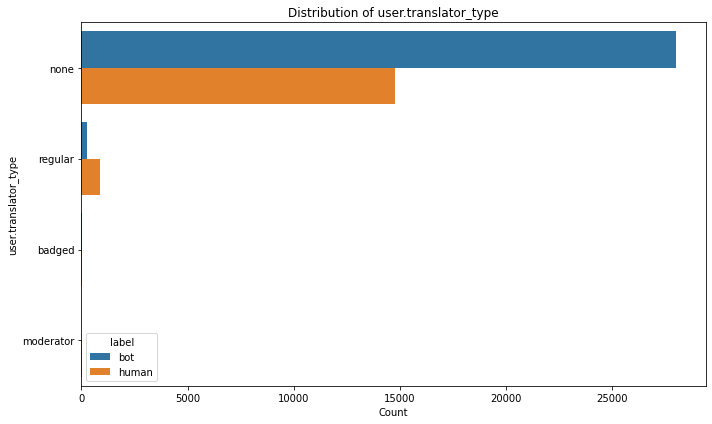


Value counts for user.translator_type:
none: 42767 (97.44%)
regular: 1116 (2.54%)
badged: 7 (0.02%)
moderator: 2 (0.00%)




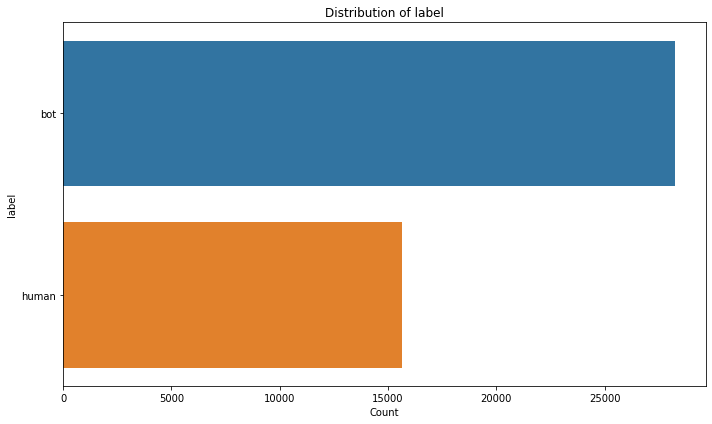


Value counts for label:
bot: 28251 (64.36%)
human: 15641 (35.64%)




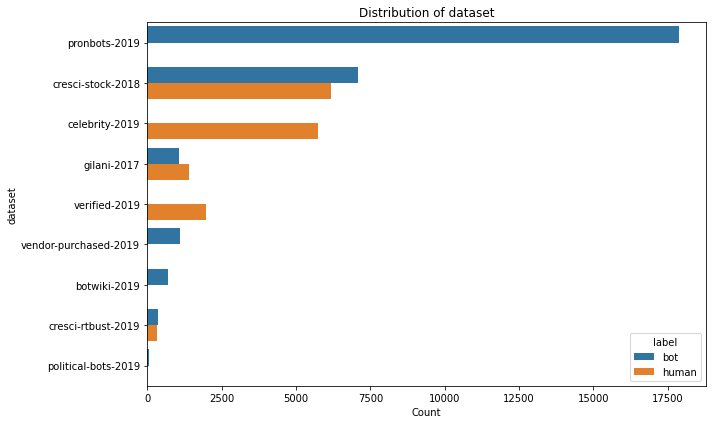


Value counts for dataset:
pronbots-2019: 17882 (40.74%)
cresci-stock-2018: 13273 (30.24%)
celebrity-2019: 5732 (13.06%)
gilani-2017: 2478 (5.65%)
verified-2019: 1987 (4.53%)
vendor-purchased-2019: 1087 (2.48%)
botwiki-2019: 698 (1.59%)
cresci-rtbust-2019: 693 (1.58%)
political-bots-2019: 62 (0.14%)




In [22]:
cat_data2 = cat_data.drop(columns=['user.entities.url.urls','user.entities.description.urls','user.withheld_in_countries'])
categorical_eda(cat_data2)

check if bots creators love emojis

In [23]:
import re

def contains_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(str(text)))

cat_data['contains_emoji'] = cat_data['user.name'].apply(contains_emoji)

crosstab('contains_emoji','label',cat_data)

crosstab f1:contains_emoji, f2:label
label             bot  human
contains_emoji              
False           27386  14326
True              865   1315


label,bot,human
contains_emoji,,
False,27386,14326
True,865,1315


nothing too significant in the dataset

### datetime data

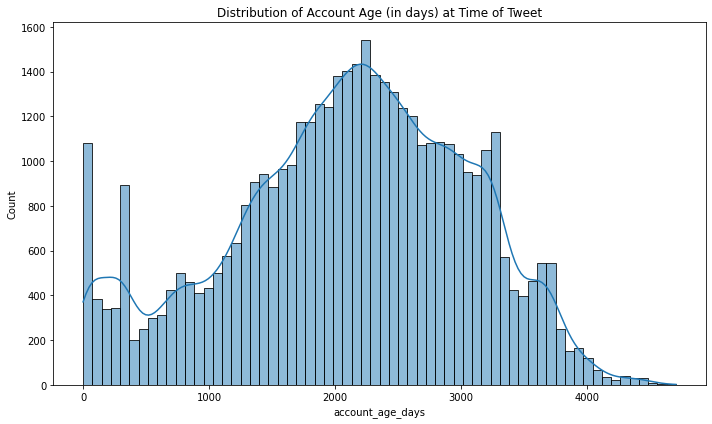

In [24]:
# Analyze dates

all_data['created_at'] = pd.to_datetime(all_data['created_at'])
all_data['user.created_at'] = pd.to_datetime(all_data['user.created_at'])



# Account age at time of tweet
all_data['account_age_days'] = (all_data['created_at'] - all_data['user.created_at']).dt.days

plt.figure(figsize=(10, 6))
ax = sns.histplot(all_data['account_age_days'], kde=True)

plt.title('Distribution of Account Age (in days) at Time of Tweet')
plt.tight_layout()
plt.show()

### Preprocessing

cleaning the data from missing values and outliers

In [25]:
df = all_data.drop(columns=['user.url','user.entities.url.urls','user.utc_offset','user.time_zone','user.lang',
                            'user.profile_background_image_url','user.profile_background_image_url_https',
                            'user.profile_banner_url','user.entities.description.urls','user.withheld_in_countries'],axis=1)
df = df.drop(columns=['dataset','user_id','user.id'],axis=1)
df = df.drop(columns=['user.protected', 'user.contributors_enabled', 'user.is_translator',
       'user.is_translation_enabled', 'user.following', 'user.follow_request_sent', 'user.notifications'],axis=1)
df = df.drop(columns=['created_at','user.created_at'],axis=1)

In [26]:
def map_bool(x):
    if x == 'bot':
        return 1
    else:
        return 0
    # return 1 if 'bot' else 0
df['label'] = df['label'].apply(map_bool)

In [27]:
df.columns

Index(['user.id_str', 'user.name', 'user.screen_name', 'user.location',
       'user.description', 'user.followers_count', 'user.friends_count',
       'user.listed_count', 'user.favourites_count', 'user.geo_enabled',
       'user.verified', 'user.statuses_count', 'user.profile_background_color',
       'user.profile_background_tile', 'user.profile_image_url',
       'user.profile_image_url_https', 'user.profile_link_color',
       'user.profile_sidebar_border_color', 'user.profile_sidebar_fill_color',
       'user.profile_text_color', 'user.profile_use_background_image',
       'user.has_extended_profile', 'user.default_profile',
       'user.default_profile_image', 'user.translator_type', 'label',
       'account_age_days'],
      dtype='object')

#### Split Data

In [28]:
y = df['label']
x = df.drop(columns=['label'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)

In [29]:
def plot_classification_metrics(y_true, y_pred):
    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    # Prepare data for plotting
    metrics = ['Precision', 'Accuracy', 'F1-macro']
    scores = [precision, accuracy, f1]

    # Create bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

    # Customize the plot
    ax.set_ylim(0, 1)
    ax.set_title('Classification Metrics Comparison', fontsize=16)
    ax.set_ylabel('Score', fontsize=12)
    
    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

    # Add a horizontal line at y=0.5 for reference
    ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)

    # Improve layout
    plt.tight_layout()

    # Show plot
    plt.show()

    conf_mat = confusion_matrix(y_true,y_pred)
    cm_display  = ConfusionMatrixDisplay(conf_mat)
    fig, ax = plt.subplots(figsize=(10, 8))
    cm_display.plot(ax=ax, cmap='Blues', values_format='d')

    # Improve the display
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()


##### run basic classifires

In [30]:
def get_transformer(x_train,is_le=False):
    categorical = x_train.dtypes == object

    preprocess = make_column_transformer(
        (StandardScaler(), ~categorical),
        (OneHotEncoder(handle_unknown="infrequent_if_exist",drop='first'), categorical))
    if is_le:
        preprocess = make_column_transformer(
        (StandardScaler(), ~categorical),
        (LabelEncoder(), categorical))
    return preprocess

In [31]:
def grid_search_model(model,param_grid,x_train, y_train,x_test,y_test,is_le=False):
    
    preprocess = get_transformer(x_train,is_le)
    
    # Define the model PL
    clf_PL = make_pipeline(preprocess, model)

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=clf_PL, param_grid=param_grid, 
                            cv=5, scoring=f1_score, n_jobs=-1)

    # Fit the GridSearchCV object to the data
    grid_search.fit(x_train, y_train)

    # Print the best parameters and score
    print("Best parameters:", grid_search.best_params_)

    # Use the best model to make predictions
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(x_test)

    plot_classification_metrics(y_test,predictions)
    return best_model,predictions

c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Best parameters: {'verbose': False}


c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


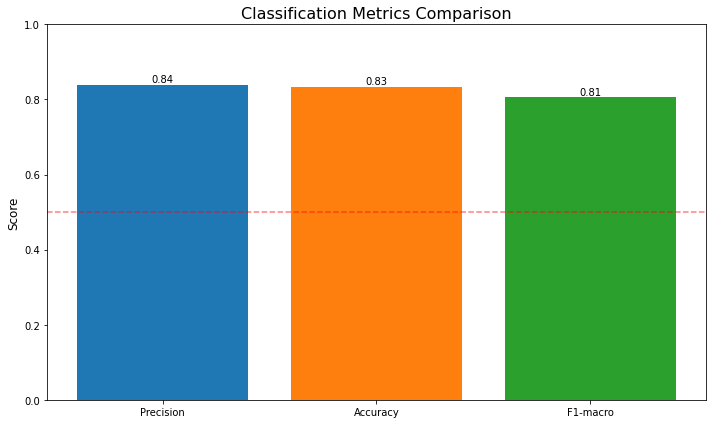

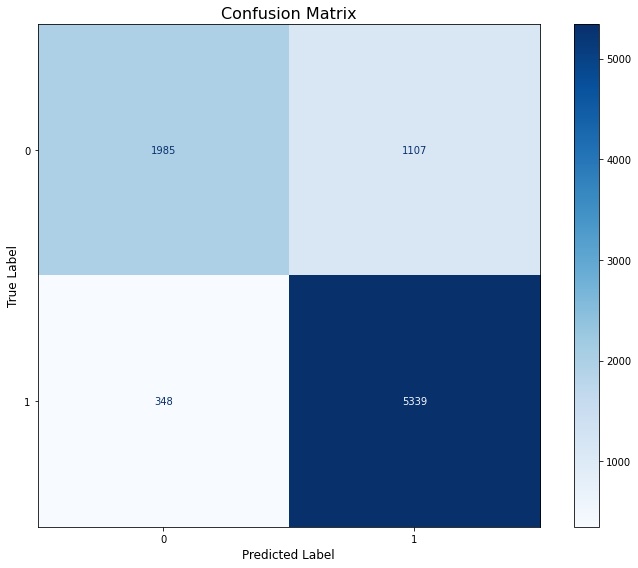

In [32]:
model = RidgeClassifier()


param_grid = {

    'verbose': [False]  # Constraint the coefficients to be positive
}
best_model,preds = grid_search_model(model,param_grid,x_train, y_train,x_test,y_test)

c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Best parameters: {'sgdclassifier__alpha': 0.0001}


c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


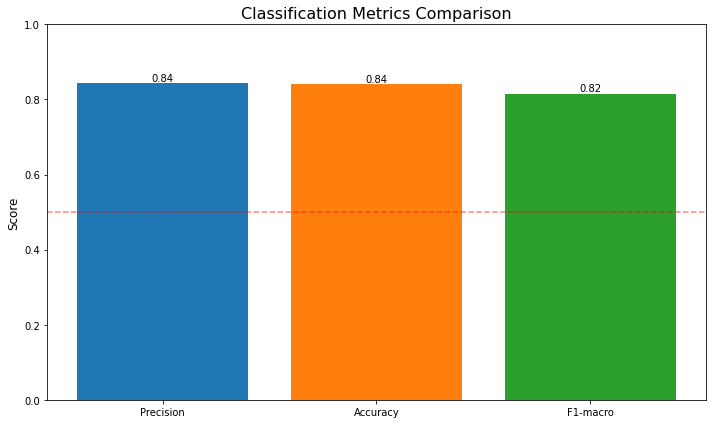

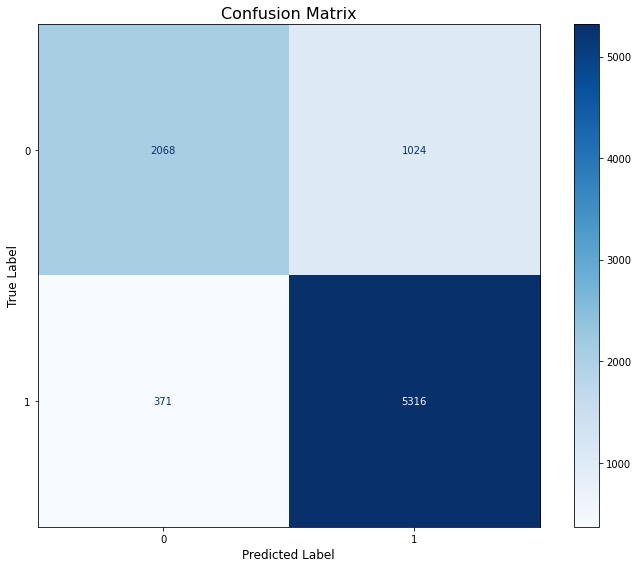

In [33]:
param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01]
}


model = SGDClassifier(random_state=42)

best_model,preds = grid_search_model(model,param_grid,x_train, y_train,x_test,y_test)

c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


Best parameters: {'xgbclassifier__learning_rate': 0.01}


c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


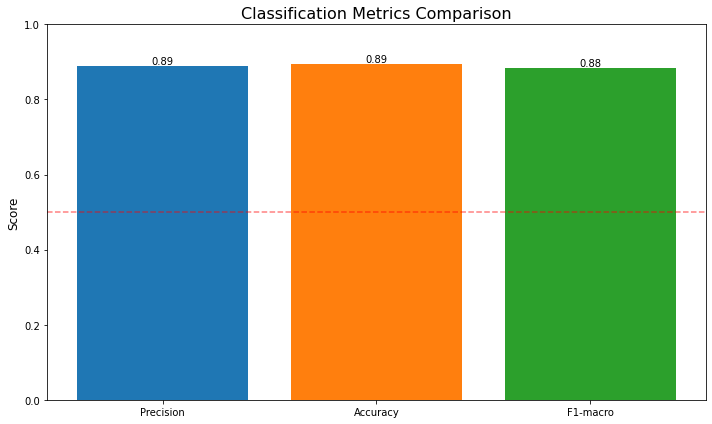

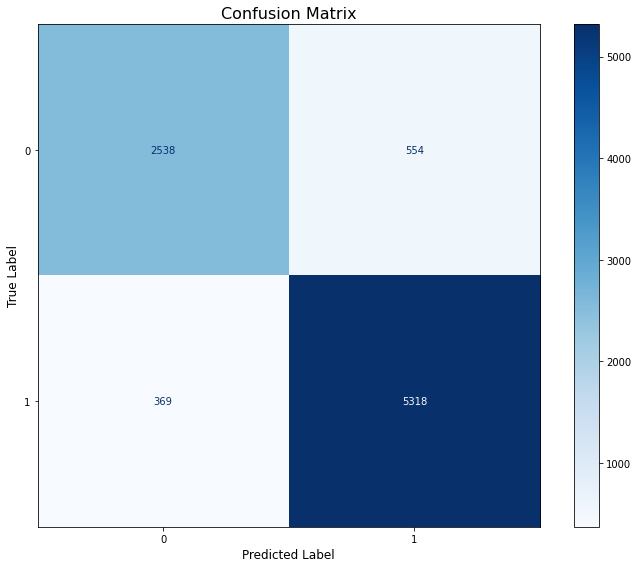

In [34]:
# Initialize the XGBoost classifier
param_grid = {
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.3],
}


model = XGBClassifier(random_state=42)

# Set up GridSearchCV
best_model,preds = grid_search_model(model,param_grid,x_train, y_train,x_test,y_test)
xgb_best_model = best_model

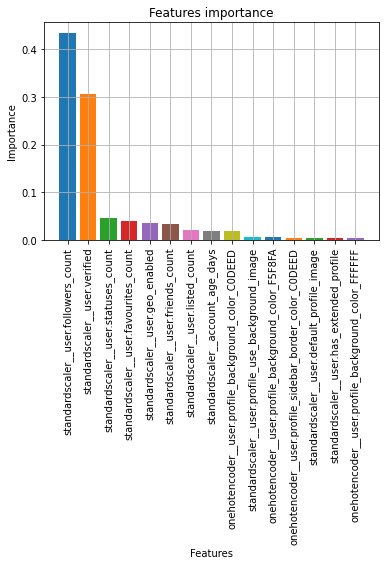

standardscaler__user.followers_count:0.4342786967754364
standardscaler__user.verified:0.30660319328308105
standardscaler__user.statuses_count:0.04701893404126167
standardscaler__user.favourites_count:0.03914346173405647
standardscaler__user.geo_enabled:0.036377914249897


In [35]:
features = xgb_best_model.named_steps['xgbclassifier'].feature_importances_
feature_names = xgb_best_model[:-1].get_feature_names_out()

indices = np.argsort(-1*abs(features))[0:15]
cp = sns.color_palette()
plt.bar(feature_names[indices], features[indices], color=cp)

plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Features importance")
plt.grid()
plt.show()
for i in range(5):
    print(f"{feature_names[indices[i]]}:{features[indices[i]]}")


#### outliers

do IQR for numeric outliers and see how it affects

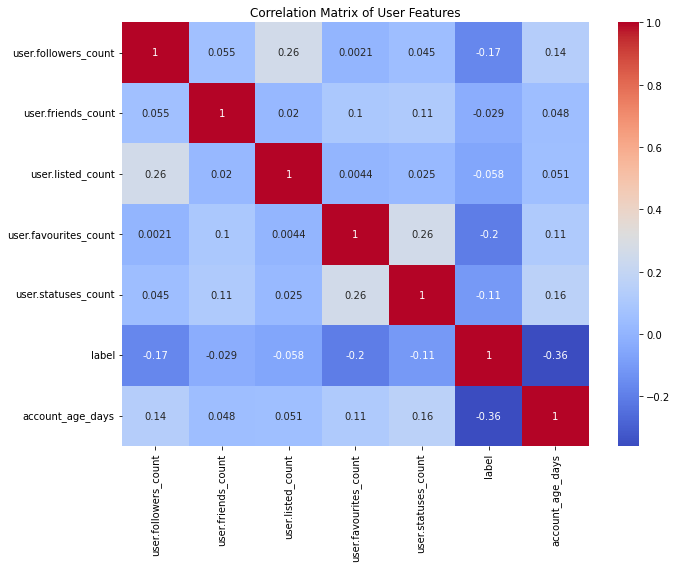

In [36]:
df2 = df.copy()
numeric = df2.select_dtypes('number').copy()
correlation_matrix = numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of User Features')
plt.tight_layout()
plt.show()

In [37]:
def outlier_handling_iqr(df, features):
    
    iqr_factor = 1.5
    df_res = df.copy()
    
    # Replace numeric outliers with np.nan

    for col in df_res.columns:
        
        if col in features:  # if numeric column
            
            # calculate Q1 and Q3 for each column
            Q1 = df_res[col].quantile(0.25)
            Q3 = df_res[col].quantile(0.75)
            median = df_res[col].quantile(0.50)
            # interquatile range (IQR)
            IQR = Q3 - Q1
           
            # replace outliers with NaN
            df_res.loc[(df_res[col] < (Q1 - iqr_factor * IQR)) | (df_res[col] > (Q3 + iqr_factor * IQR)), col] = median
 
    return df_res

In [38]:
numeric_cols_irq = ['user.followers_count', 'user.friends_count', 'user.listed_count',
       'user.favourites_count', 'user.statuses_count']
df2 = outlier_handling_iqr(df2,numeric_cols_irq)

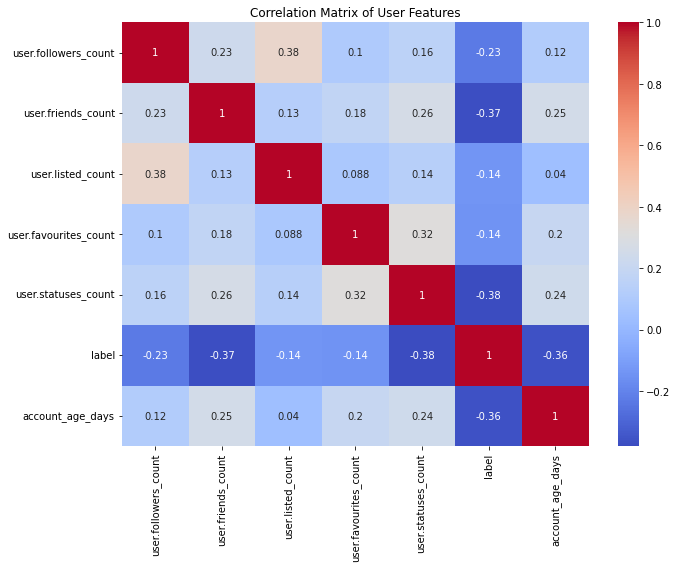

In [39]:
numeric = df2.select_dtypes('number').copy()
correlation_matrix = numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of User Features')
plt.tight_layout()
plt.show()

c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Best parameters: {'xgbclassifier__learning_rate': 0.01}


c:\Users\idang\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


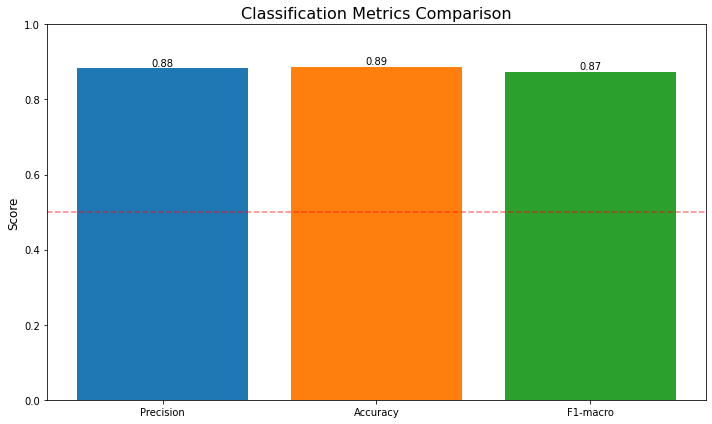

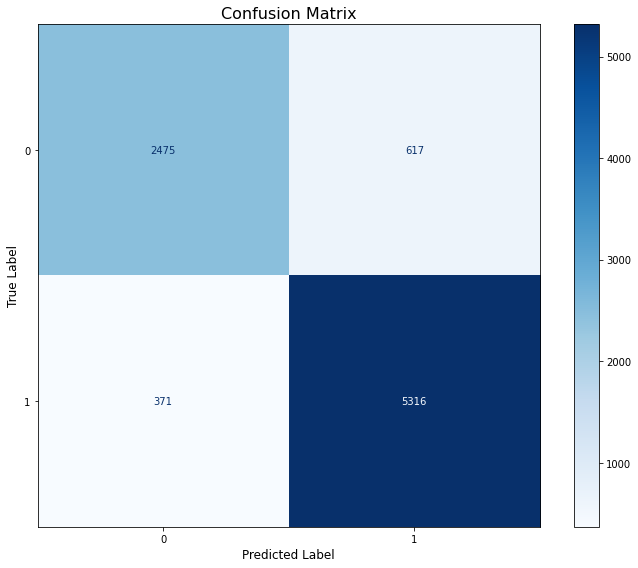

In [40]:
y = df2['label']
x = df2.drop(columns=['label'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)
model = RidgeClassifier()


# Initialize the XGBoost classifier
param_grid = {
    'xgbclassifier__learning_rate': [0.01],
}

model = XGBClassifier(random_state=42)

# Set up GridSearchCV
best_model,preds = grid_search_model(model,param_grid,x_train, y_train,x_test,y_test)
xgb_best_model = best_model

we see that human detection (when we classify 0) is a little worse 2475 instead of 2538

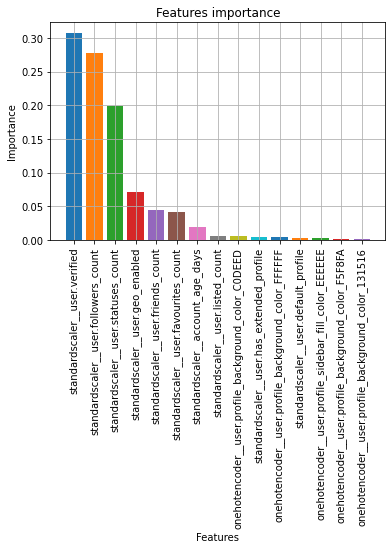

standardscaler__user.verified:0.30766525864601135
standardscaler__user.followers_count:0.2770106792449951
standardscaler__user.statuses_count:0.19890259206295013
standardscaler__user.geo_enabled:0.071512371301651
standardscaler__user.friends_count:0.04458955302834511


In [41]:
features = xgb_best_model.named_steps['xgbclassifier'].feature_importances_
feature_names = xgb_best_model[:-1].get_feature_names_out()

indices = np.argsort(-1*abs(features))[0:15]
cp = sns.color_palette()
plt.bar(feature_names[indices], features[indices], color=cp)

plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Features importance")
plt.grid()
plt.show()
for i in range(5):
    print(f"{feature_names[indices[i]]}:{features[indices[i]]}")

before iqr:<br>
standardscaler__user.followers_count:0.4342786967754364<br>
standardscaler__user.verified:0.30660319328308105<br>
standardscaler__user.statuses_count:0.04701893404126167<br>
standardscaler__user.favourites_count:0.03914346173405647<br>
standardscaler__user.geo_enabled:0.036377914249897<br>


we see that followers_count is more significant before iqr, and after iqr statuses_count is more significant<br>
funny fact - the color 0xC0DEED (funny name for our domain) for profile backgound color and and sidebar boarder color are indicatores in the xgboost classifier.

## Conclusion

* we see that pretty easially with the data we get to 0.88 f1 score. 
* there are many features where we can see a discrimination betwen bots and human users (user.verified.user.followers_count,user.status_count,etc.)



### Further work
* Checking our model with newer dataset to see if we managed to really learn this domain.
* Try to attack the problem of disscussion in the social media from a different angle of grading how a user is leaning towards some view.

## Bibliography

* https://www.kaggle.com/code/leeyj0511/kor-binary-classification-eda-feature-select#Feature-Selection-and-Random-Forest-Classification
* https://botometer.osome.iu.edu/bot-repository/datasets.html